In [9]:
#Standard Data Wrangling and Presentation
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

## URL Processing
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize
from urllib.request import urlopen
import ssl
import csv
print('Import Complete')


Import Complete


In [10]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')
#print(soup.prettify()
print('data ready')

data ready


In [11]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table = soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df = df[~df['PostalCode'].isnull()]  # to filter out bad rows
df.head()

PostalCode             Borough                  Neighborhood
0      M1A\n      Not assigned\n                            \n
1      M2A\n      Not assigned\n                            \n
2      M3A\n        North York\n                   Parkwoods\n
3      M4A\n        North York\n            Victoria Village\n
4      M5A\n  Downtown Toronto\n  Regent Park / Harbourfront\n

In [12]:
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)
df1 = df.reset_index()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
index           180 non-null int64
PostalCode      180 non-null object
Borough         180 non-null object
Neighborhood    180 non-null object
dtypes: int64(1), object(3)
memory usage: 5.7+ KB


In [13]:
df2= df1.groupby('PostalCode').agg(lambda x: ','.join(x))
df2.head()

Borough                              Neighborhood
PostalCode                                                          
M1A\n       Not assigned\n                                          
M1B\n        Scarborough\n                           Malvern / Rouge
M1C\n        Scarborough\n  Rouge Hill / Port Union / Highland Creek
M1E\n        Scarborough\n       Guildwood / Morningside / West Hill
M1G\n        Scarborough\n                                    Woburn

In [14]:
df2["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)
df.head()

PostalCode           Borough                                  Neighborhood
2      M3A\n        North York                                     Parkwoods
3      M4A\n        North York                              Victoria Village
4      M5A\n  Downtown Toronto                    Regent Park / Harbourfront
5      M6A\n        North York             Lawrence Manor / Lawrence Heights
6      M7A\n  Downtown Toronto  Queen's Park / Ontario Provincial Government

In [15]:
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df2 = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df2.head()

PostalCode      Borough                              Neighborhood
0        M1B  Scarborough                           Malvern / Rouge
1        M1C  Scarborough  Rouge Hill / Port Union / Highland Creek
2        M1E  Scarborough       Guildwood / Morningside / West Hill
3        M1G  Scarborough                                    Woburn
4        M1H  Scarborough                                 Cedarbrae

In [16]:
df2.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)
df2 = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df2 = df[~df['PostalCode'].isnull()]  # to filter out bad rows
df2.head(14)

PostalCode           Borough  \
2         M3A        North York   
3         M4A        North York   
4         M5A  Downtown Toronto   
5         M6A        North York   
6         M7A  Downtown Toronto   
8         M9A         Etobicoke   
9         M1B       Scarborough   
11        M3B        North York   
12        M4B         East York   
13        M5B  Downtown Toronto   
14        M6B        North York   
17        M9B         Etobicoke   
18        M1C       Scarborough   
20        M3C        North York   

                                         Neighborhood  
2                                           Parkwoods  
3                                    Victoria Village  
4                          Regent Park / Harbourfront  
5                   Lawrence Manor / Lawrence Heights  
6        Queen's Park / Ontario Provincial Government  
8                                    Islington Avenue  
9                                     Malvern / Rouge  
11                                          Don Mills  
12                   Parkview Hill / Woodbine Gardens  
13                           Garden District, Ryerson  
14                                          Glencairn  
17  West Deane Park / Princess Gardens / Martin Gr...  
18           Rouge Hill / Port Union / Highland Creek  
20                                          Don Mills

In [17]:
df2.shape

(103, 3)

In [18]:
#Processing LatLong of neighbourhoods
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

#using soup object, iterate the .wikitable to get the data from the HTML page and store it into a list
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert list into Pandas DataFrame
canada_df = pd.DataFrame(data = data,columns = columns)
canada_df.head()

Postal code           Borough                Neighborhood
0         M1A      Not assigned                            
1         M2A      Not assigned                            
2         M3A        North York                   Parkwoods
3         M4A        North York            Victoria Village
4         M5A  Downtown Toronto  Regent Park / Harbourfront

In [19]:
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df["Neighborhood"] = canada_df.groupby("Postal code")["Neighborhood"].transform(lambda neigh: ', '.join(neigh))

#remove duplicates
canada_df = canada_df.drop_duplicates()

#update index to be postcode if it isn't already
if(canada_df.index.name != 'Postal code'):
    canada_df = canada_df.set_index('Postal code')
    
canada_df.head()

Borough                                  Neighborhood
Postal code                                                                
M3A                North York                                     Parkwoods
M4A                North York                              Victoria Village
M5A          Downtown Toronto                    Regent Park / Harbourfront
M6A                North York             Lawrence Manor / Lawrence Heights
M7A          Downtown Toronto  Queen's Park / Ontario Provincial Government

In [20]:
#Get data lat/long data from csv
lat_long_coord_df = pd.read_csv("http://cocl.us/Geospatial_data")

#rename columns and set the index to be Postcode
lat_long_coord_df.columns = ["Postcode", "Latitude", "Longitude"]
if(lat_long_coord_df.index.name != 'Postcode'):
    lat_long_coord_df = lat_long_coord_df.set_index('Postcode')
    
lat_long_coord_df.head()

Latitude  Longitude
Postcode                      
M1B       43.806686 -79.194353
M1C       43.784535 -79.160497
M1E       43.763573 -79.188711
M1G       43.770992 -79.216917
M1H       43.773136 -79.239476

In [21]:
canada_df = canada_df.join(lat_long_coord_df)
canada_df.head(11)


Borough                                  Neighborhood  \
Postal code                                                                   
M3A                North York                                     Parkwoods   
M4A                North York                              Victoria Village   
M5A          Downtown Toronto                    Regent Park / Harbourfront   
M6A                North York             Lawrence Manor / Lawrence Heights   
M7A          Downtown Toronto  Queen's Park / Ontario Provincial Government   
M9A                 Etobicoke                              Islington Avenue   
M1B               Scarborough                               Malvern / Rouge   
M3B                North York                                     Don Mills   
M4B                 East York              Parkview Hill / Woodbine Gardens   
M5B          Downtown Toronto                      Garden District, Ryerson   
M6B                North York                                     Glencairn   

              Latitude  Longitude  
Postal code                        
M3A          43.753259 -79.329656  
M4A          43.725882 -79.315572  
M5A          43.654260 -79.360636  
M6A          43.718518 -79.464763  
M7A          43.662301 -79.389494  
M9A          43.667856 -79.532242  
M1B          43.806686 -79.194353  
M3B          43.745906 -79.352188  
M4B          43.706397 -79.309937  
M5B          43.657162 -79.378937  
M6B          43.709577 -79.445073

In [22]:
toronto_df = canada_df[canada_df['Borough'].str.contains('Toronto')]
toronto_df.head()

Borough                                  Neighborhood  \
Postal code                                                                   
M5A          Downtown Toronto                    Regent Park / Harbourfront   
M7A          Downtown Toronto  Queen's Park / Ontario Provincial Government   
M5B          Downtown Toronto                      Garden District, Ryerson   
M5C          Downtown Toronto                                St. James Town   
M4E              East Toronto                                   The Beaches   

              Latitude  Longitude  
Postal code                        
M5A          43.654260 -79.360636  
M7A          43.662301 -79.389494  
M5B          43.657162 -79.378937  
M5C          43.651494 -79.375418  
M4E          43.676357 -79.293031

In [24]:
#Show an initial map of the neighborhoods in Toronto
!pip install folium==0.5.0 
import folium # map rendering library
# create map of Toronto using first entries latitude and longitude values
map_toronto = folium.Map(location=[toronto_df["Latitude"][0], toronto_df["Longitude"][0]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

     |████████████████████████████████| 81kB 10.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium


In [25]:
# Exploring Venues using FourSquare
CLIENT_ID = '1ZSS0AYQC2LGFCTQM03BJTM0ALRPEO5PNCCV5EMCHODJ4A5J' # your Foursquare ID
CLIENT_SECRET = 'FDUEBJGXQZEVJOTYKYEB50SFHI4CGZGECVBEDWKL2YS2OYF5' # your Foursquare Secret
VERSION = '20200409' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1ZSS0AYQC2LGFCTQM03BJTM0ALRPEO5PNCCV5EMCHODJ4A5J
CLIENT_SECRET:FDUEBJGXQZEVJOTYKYEB50SFHI4CGZGECVBEDWKL2YS2OYF5


In [26]:
# Extracting those boroughs which got Toronto in it from the original data frame finalgeodf

Finaldf = toronto_df.loc[toronto_df['Borough'].str.contains('Toronto')].reset_index()
Finaldf.shape
Finaldf.head()

Postal code           Borough                                  Neighborhood  \
0         M5A  Downtown Toronto                    Regent Park / Harbourfront   
1         M7A  Downtown Toronto  Queen's Park / Ontario Provincial Government   
2         M5B  Downtown Toronto                      Garden District, Ryerson   
3         M5C  Downtown Toronto                                St. James Town   
4         M4E      East Toronto                                   The Beaches   

    Latitude  Longitude  
0  43.654260 -79.360636  
1  43.662301 -79.389494  
2  43.657162 -79.378937  
3  43.651494 -79.375418  
4  43.676357 -79.293031

In [27]:
Finaldf.loc[4,'Neighborhood']

'The Beaches'

In [28]:
neighborhood_latitude = Finaldf.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Finaldf.loc[10, 'Longitude'] # neighborhood longitude value

neighborhood_name = Finaldf.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.6408157, -79.38175229999999.


In [29]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=1ZSS0AYQC2LGFCTQM03BJTM0ALRPEO5PNCCV5EMCHODJ4A5J&client_secret=FDUEBJGXQZEVJOTYKYEB50SFHI4CGZGECVBEDWKL2YS2OYF5&v=20200409&ll=43.6408157,-79.38175229999999&radius=500&limit=100'

In [31]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e951126fb34b5001c437977'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Harbourfront',
  'headerFullLocation': 'Harbourfront, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 150,
  'suggestedBounds': {'ne': {'lat': 43.6453157045, 'lng': -79.37554568947675},
   'sw': {'lat': 43.636315695499995, 'lng': -79.38795891052322}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bfaa3494a67c928d08528cf',
       'name': 'Harbourfront',
       'location': {'lat': 43.639525632239106,
        'lng': -79.38068838052389,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.639525632239106,
          'lng': -79.3806

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name           categories        lat        lng
0         Harbourfront         Neighborhood  43.639526 -79.380688
1      Roundhouse Park                 Park  43.641745 -79.384279
2           iQ Food Co          Salad Place  43.642851 -79.382081
3          BeaverTails         Dessert Shop  43.639736 -79.380068
4  Real Sports Apparel  Sporting Goods Shop  43.642860 -79.380184

In [35]:
nearby_venues

name  \
0                                  Harbourfront   
1                               Roundhouse Park   
2                                    iQ Food Co   
3                                   BeaverTails   
4                           Real Sports Apparel   
5                             Evviva Restaurant   
6                                  Lake Ontario   
7                     Longo's Maple Leaf Square   
8                           Harbourfront Centre   
9                              Natrel Pond/Rink   
10             Delta Hotels by Marriott Toronto   
11                            Maple Leaf Square   
12                          Harbour Square Park   
13                                      e11even   
14                                     Sharetea   
15                               Ontario Square   
16                             Taverna Mercatto   
17                           Aroma Espresso Bar   
18                                Boxcar Social   
19                                         Miku   
20                             RS - Real Sports   
21                               Lick It Gelato   
22                              The Power Plant   
23                             SOCO Kitchen+Bar   
24                                        TELUS   
25                           Pearl Harbourfront   
26                          Fleck Dance Theater   
27                             Le Germain Hotel   
28                              Air Canada Club   
29                             Scotiabank Arena   
30                    Delta Toronto Club Lounge   
31                  Ripley's Aquarium of Canada   
32                                      Mos Mos   
33                        Union Pearson Express   
34                                      PawsWay   
35                        Corks Beer & Wine Bar   
36                        Steam Whistle Brewing   
37                                      Ray Bay   
38                   Steam Whistle's Biergarten   
39                           Lavazza Espression   
40                                      Sky Pod   
41                                     Joe Bird   
42                                Rogers Centre   
43                                        WVRST   
44                              Balzac's Coffee   
45                                     CN Tower   
46                             Dangerous Lagoon   
47                                 The Rec Room   
48              Toronto Railway Heritage Centre   
49                        Pilot Coffee Roasters   
50                   Labatt Breweries of Canada   
51                          Amsterdam Brewhouse   
52                                      Pie Bar   
53                                       Subway   
54                                Kupfert & Kim   
55                                    Starbucks   
56                                Union Chicken   
57                           Harbour 60 Toronto   
58              Gonoe Sushi Japanese Restaurant   
59                                       Panago   
60                               360 Restaurant   
61                                  Amano Pasta   
62                                 Rainbow Reef   
63           The Westin Harbour Castle, Toronto   
64                                       McCafé   
65                                  Tim Hortons   
66                                  Glass Floor   
67                                    Starbucks   
68                           Aroma Espresso Bar   
69  Radisson Admiral Hotel Toronto-Harbourfront   
70                                    Starbucks   
71                       Toronto Railway Museum   
72                               Kellys Landing   
73                       Harbourfront Wavedecks   
74            World Café at Harbourfront Centre   
75                            Buster's Sea Cove   
76                   The Chartroom Bar & Lounge   
77                                    Dollarama   
78            

In [36]:
#Now to process the remaining neighbourhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
DownTownToronto_venues = getNearbyVenues(names=Finaldf['Neighborhood'],
                                   latitudes=Finaldf['Latitude'],
                                   longitudes=Finaldf['Longitude']
                                  )

Regent Park / Harbourfront
Queen's Park / Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
The Danforth West / Riverdale
Toronto Dominion Centre / Design Exchange
Brockton / Parkdale Village / Exhibition Place
India Bazaar / The Beaches West
Commerce Court / Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park / The Junction South
North Toronto West
The Annex / North Midtown / Yorkville
Parkdale / Roncesvalles
Davisville
University of Toronto / Harbord
Runnymede / Swansea
Moore Park / Summerhill East
Kensington Market / Chinatown / Grange Park
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport
Rosed

In [38]:
DownTownToronto_venues.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park / Harbourfront               43.65426              -79.360636   
1  Regent Park / Harbourfront               43.65426              -79.360636   
2  Regent Park / Harbourfront               43.65426              -79.360636   
3  Regent Park / Harbourfront               43.65426              -79.360636   
4  Regent Park / Harbourfront               43.65426              -79.360636   
5  Regent Park / Harbourfront               43.65426              -79.360636   
6  Regent Park / Harbourfront               43.65426              -79.360636   
7  Regent Park / Harbourfront               43.65426              -79.360636   
8  Regent Park / Harbourfront               43.65426              -79.360636   
9  Regent Park / Harbourfront               43.65426              -79.360636   

                              Venue  Venue Latitude  Venue Longitude  \
0                  Roselle Desserts       43.653447       -79.362017   
1                     Tandem Coffee       43.653559       -79.361809   
2            Cooper Koo Family YMCA       43.653249       -79.358008   
3               Body Blitz Spa East       43.654735       -79.359874   
4                Morning Glory Cafe       43.653947       -79.361149   
5                    Impact Kitchen       43.656369       -79.356980   
6                   Corktown Common       43.655618       -79.356211   
7            Figs Breakfast & Lunch       43.655675       -79.364503   
8  The Distillery Historic District       43.650244       -79.359323   
9          Dominion Pub and Kitchen       43.656919       -79.358967   

        Venue Category  
0               Bakery  
1          Coffee Shop  
2  Distribution Center  
3                  Spa  
4       Breakfast Spot  
5           Restaurant  
6                 Park  
7       Breakfast Spot  
8        Historic Site  
9                  Pub

In [39]:
DownTownToronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Berczy Park                                                            55   
Brockton / Parkdale Village / Exhibition Place                         23   
Business reply mail Processing CentrE                                  16   
CN Tower / King and Spadina / Railway Lands / H...                     14   
Central Bay Street                                                     64   
Christie                                                               18   
Church and Wellesley                                                   75   
Commerce Court / Victoria Hotel                                       100   
Davisville                                                             34   
Davisville North                                                        7   
Dufferin / Dovercourt Village                                          15   
First Canadian Place / Underground city                               100   
Forest Hill North & West                                                5   
Garden District, Ryerson                                              100   
Harbourfront East / Union Station / Toronto Isl...                    100   
High Park / The Junction South                                         24   
India Bazaar / The Beaches West                                        20   
Kensington Market / Chinatown / Grange Park                            62   
Lawrence Park                                                           3   
Little Portugal / Trinity                                              43   
Moore Park / Summerhill East                                            3   
North Toronto West                                                     19   
Parkdale / Roncesvalles                                                14   
Queen's Park / Ontario Provincial Government                           32   
Regent Park / Harbourfront                                             49   
Richmond / Adelaide / King                                             97   
Rosedale                                                                4   
Roselawn                                                                2   
Runnymede / Swansea                                                    40   
St. James Town                                                         85   
St. James Town / Cabbagetown                                           43   
Stn A PO Boxes                                                         95   
Studio District                                                        40   
Summerhill West / Rathnelly / South Hill / Fore...                     17   
The Annex / North Midtown / Yorkville                                  22   
The Beaches                                                             4   
The Danforth West / Riverdale                                          43   
Toronto Dominion Centre / Design Exchange                             100   
University of Toronto / Harbord                                        35   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Berczy Park                                                             55   
Brockton / Parkdale Village / Exhibition Place                          23   
Business reply mail Processing CentrE                                   16   
CN Tower / King and Spadina / Railway Lands / H...                      14   
Central Bay Street                                                      64   
Christie                                                                18   
Church and Wellesley                                                    75   
Commerce Court / Victoria Hotel                                        100   
Davisville                                                              34   
Davisville North                    

In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(DownTownToronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = DownTownToronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Yoga Studio  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0            0        0                   0             0               0   
1            0        0                   0             0               0   
2            0        0                   0             0               0   
3            0        0                   0             0               0   
4            0        0                   0             0               0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0                0                 0                    0             0   
1                0                 0                    0             0   
2                0                 0                    0             0   
3                0                 0                    0             0   
4                0                 0                    0             0   

   Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0         0            0                    0                 0   
1         0            0                    0                 0   
2         0            0                    0                 0   
3         0            0                    0                 0   
4         0            0                    0                 0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  \
0                   0              0          0           0           0   
1                   0              0          0           0           0   
2                   0              0          0           0           0   
3                   0              0          0           0           0   
4                   0              0          0           0           0   

   Bakery  Bank  Bar  Baseball Stadium  Basketball Stadium  Beach  \
0       1     0    0                 0                   0      0   
1       0     0    0                 0                   0      0   
2       0     0    0                 0                   0      0   
3       0     0    0                 0                   0      0   
4       0     0    0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0                0         0           0                   0       0   
1                0         0           0                   0       0   
2                0         0           0                   0       0   
3                0         0           0                   0       0   
4                0         0           0                   0       0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               1   

   Brewery  Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0        0                0         0             0              0         0   
1        0                0         0             0              0         0   
2        0                0         0             0              0         0   
3        0                0         0             0              0         0   
4        0                0         0             0              0         0   

   Butcher  Café  Cajun / Creole Restaurant  Candy Store  \
0        0     0                          0            0   
1        0     0                          0            0   
2        0     0                          0            0   
3        0     0                          0            0   
4        0     0                          0            0   

   Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Sh

In [41]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Yoga Studio   Airport  \
0                                         Berczy Park     0.000000  0.000000   
1      Brockton / Parkdale Village / Exhibition Place     0.000000  0.000000   
2               Business reply mail Processing CentrE     0.000000  0.000000   
3   CN Tower / King and Spadina / Railway Lands / ...     0.000000  0.071429   
4                                  Central Bay Street     0.015625  0.000000   
5                                            Christie     0.000000  0.000000   
6                                Church and Wellesley     0.026667  0.000000   
7                     Commerce Court / Victoria Hotel     0.000000  0.000000   
8                                          Davisville     0.000000  0.000000   
9                                    Davisville North     0.000000  0.000000   
10                      Dufferin / Dovercourt Village     0.000000  0.000000   
11            First Canadian Place / Underground city     0.000000  0.000000   
12                           Forest Hill North & West     0.000000  0.000000   
13                           Garden District, Ryerson     0.000000  0.000000   
14  Harbourfront East / Union Station / Toronto Is...     0.000000  0.000000   
15                     High Park / The Junction South     0.000000  0.000000   
16                    India Bazaar / The Beaches West     0.000000  0.000000   
17        Kensington Market / Chinatown / Grange Park     0.000000  0.000000   
18                                      Lawrence Park     0.000000  0.000000   
19                          Little Portugal / Trinity     0.023256  0.000000   
20                       Moore Park / Summerhill East     0.000000  0.000000   
21                                 North Toronto West     0.052632  0.000000   
22                            Parkdale / Roncesvalles     0.000000  0.000000   
23       Queen's Park / Ontario Provincial Government     0.031250  0.000000   
24                         Regent Park / Harbourfront     0.020408  0.000000   
25                         Richmond / Adelaide / King     0.000000  0.000000   
26                                           Rosedale     0.000000  0.000000   
27                                           Roselawn     0.000000  0.000000   
28                                Runnymede / Swansea     0.025000  0.000000   
29                                     St. James Town     0.000000  0.000000   
30                       St. James Town / Cabbagetown     0.000000  0.000000   
31                                     Stn A PO Boxes     0.010526  0.000000   
32                                    Studio District     0.025000  0.000000   
33  Summerhill West / Rathnelly / South Hill / For...     0.000000  0.000000   
34              The Annex / North Midtown / Yorkville     0.000000  0.000000   
35                                        The Beaches     0.000000  0.000000   
36                      The Danforth West / Riverdale     0.023256  0.000000   
37          Toronto Dominion Centre / Design Exchange     0.000000  0.000000   
38                    University of Toronto / Harbord     0.028571  0.000000   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.000000      0.000000        0.000000         0.000000   
1             0.000000      0.000000        0.000000         0.000000   
2             0.000000      0.000000        0.000000         0.000000   
3             0.071429      0.071429        0.142857         0.142857   
4             0.000000      0.000000        0.000000         0.000000   
5             0.000000      0.000000        0.000000         0.000000   
6             0.000000      0.000000        0.000000         0.000000   
7             0.000000      0.000000        0.000000         0.000000   
8             0.000000      0.000000        0.000000         0.000000   
9             0.000000      0.000000        0.000000         0.000000   
10            0.000000      0.000000 

In [42]:
#method to sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue  \
0                                         Berczy Park           Coffee Shop   
1      Brockton / Parkdale Village / Exhibition Place                  Café   
2               Business reply mail Processing CentrE            Skate Park   
3   CN Tower / King and Spadina / Railway Lands / ...        Airport Lounge   
4                                  Central Bay Street           Coffee Shop   
5                                            Christie         Grocery Store   
6                                Church and Wellesley           Coffee Shop   
7                     Commerce Court / Victoria Hotel           Coffee Shop   
8                                          Davisville           Pizza Place   
9                                    Davisville North                 Hotel   
10                      Dufferin / Dovercourt Village              Pharmacy   
11            First Canadian Place / Underground city           Coffee Shop   
12                           Forest Hill North & West                  Park   
13                           Garden District, Ryerson           Coffee Shop   
14  Harbourfront East / Union Station / Toronto Is...           Coffee Shop   
15                     High Park / The Junction South    Mexican Restaurant   
16                    India Bazaar / The Beaches West                  Park   
17        Kensington Market / Chinatown / Grange Park                  Café   
18                                      Lawrence Park                  Park   
19                          Little Portugal / Trinity                   Bar   
20                       Moore Park / Summerhill East            Playground   
21                                 North Toronto West           Coffee Shop   
22                            Parkdale / Roncesvalles             Gift Shop   
23       Queen's Park / Ontario Provincial Government           Coffee Shop   
24                         Regent Park / Harbourfront           Coffee Shop   
25                         Richmond / Adelaide / King           Coffee Shop   
26                                           Rosedale                  Park   
27                                           Roselawn          Home Service   
28                                Runnymede / Swansea           Coffee Shop   
29                                     St. James Town           Coffee Shop   
30                       St. James Town / Cabbagetown           Coffee Shop   
31                                     Stn A PO Boxes           Coffee Shop   
32                                    Studio District                  Café   
33  Summerhill West / Rathnelly / South Hill / For...                   Pub   
34              The Annex / North Midtown / Yorkville        Sandwich Place   
35                                        The Beaches                 Trail   
36                      The Danforth West / Riverdale      Greek Restaurant   
37          Toronto Dominion Centre / Design Exchange           Coffee Shop   
38                    University of Toronto / Harbord                  Café   

   2nd Most Common Venue      3rd Most Common Venue  \
0     Italian Restaurant                   Beer Bar   
1         Breakfast Spot                Coffee Shop   
2             Restaurant              Burrito Place   
3        Airport Service           Airport Terminal   
4     Italian Restaurant                       Café   
5                   Café                       Park   
6    Japanese Restaurant                    Gay Bar   
7                   Café                 Restaurant   
8           Dessert Shop             Sandwich Place   
9                   Park                        Gym   
10                Bakery  Middle Eastern Restaurant   
11                  Café                 Restaurant   
12         Jewelry Store                      Trail   
13        Clothing Store                       Café   
14              Aquarium                       Café   


In [45]:
!pip install wordcloud==1.4.1
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
print ('Wordcloud is installed and imported!')
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

Wordcloud is installed and imported!


In [57]:
df1 = (DownTownToronto_venues.groupby('Neighborhood')['Venue Category']
       .apply(lambda x: ','.join(set(x.dropna())))
       .reset_index())
max_words = 90
stopwords = set(STOPWORDS)

df1.shape
df1.columns.values

       

array(['Neighborhood', 'Venue Category'], dtype=object)


----------- Analyziing Berczy Park Neighborhood ------------




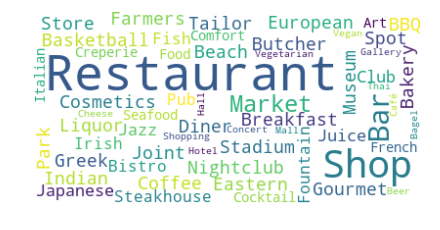


 Analyziing Brockton / Parkdale Village / Exhibition Place Neighborhood 




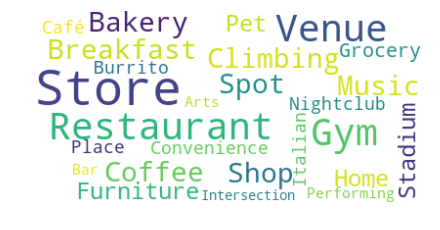


 Analyziing Business reply mail Processing CentrE Neighborhood 




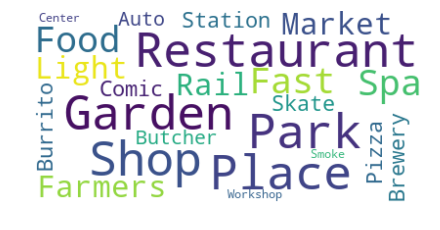


 Analyziing CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport Neighborhood 




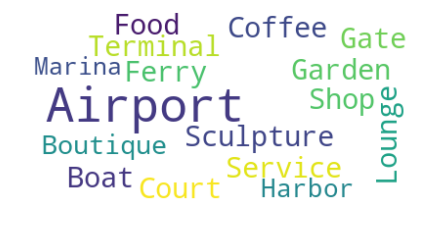


-------- Analyziing Central Bay Street Neighborhood --------




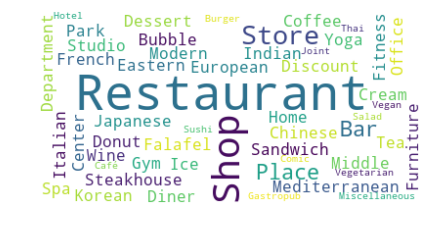


------------- Analyziing Christie Neighborhood -------------




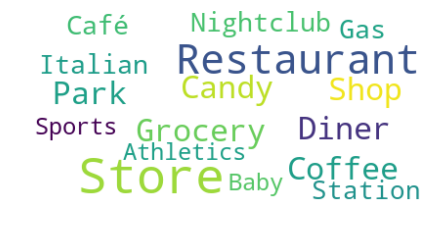


------- Analyziing Church and Wellesley Neighborhood -------




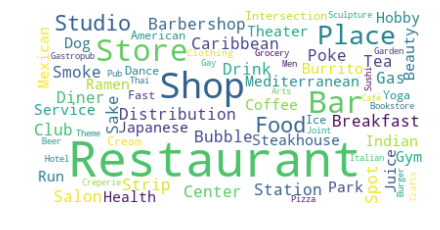


- Analyziing Commerce Court / Victoria Hotel Neighborhood --




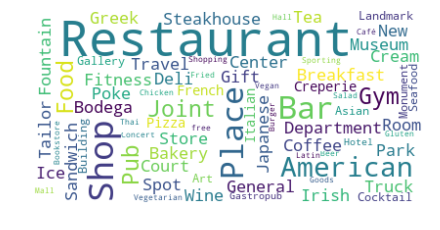


------------ Analyziing Davisville Neighborhood ------------




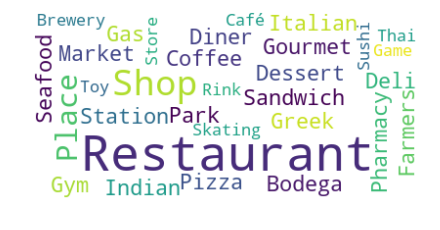


--------- Analyziing Davisville North Neighborhood ---------




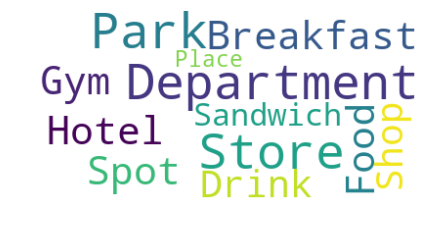


-- Analyziing Dufferin / Dovercourt Village Neighborhood ---




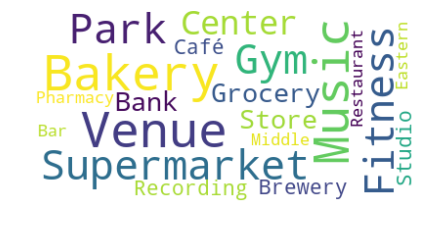


 Analyziing First Canadian Place / Underground city Neighborhood 




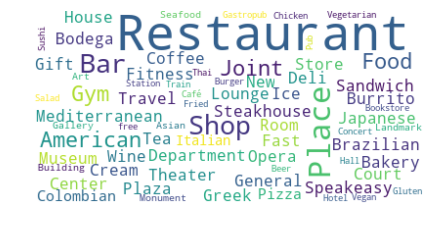


----- Analyziing Forest Hill North & West Neighborhood -----




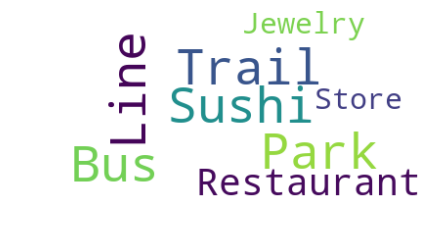


----- Analyziing Garden District, Ryerson Neighborhood -----




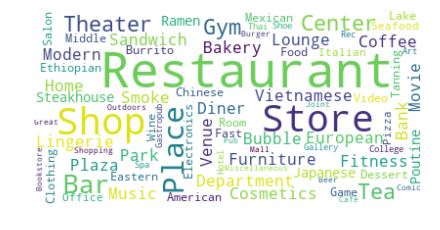


 Analyziing Harbourfront East / Union Station / Toronto Islands Neighborhood 




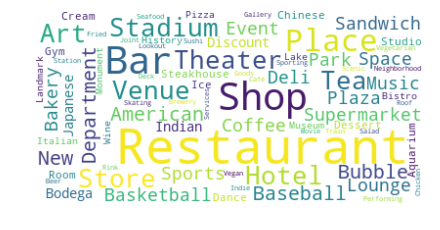


-- Analyziing High Park / The Junction South Neighborhood --




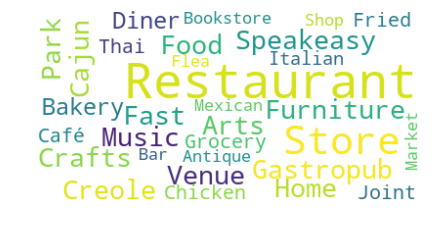


- Analyziing India Bazaar / The Beaches West Neighborhood --




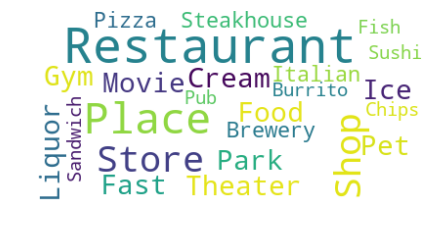


 Analyziing Kensington Market / Chinatown / Grange Park Neighborhood 




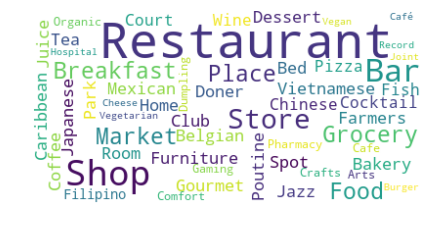


---------- Analyziing Lawrence Park Neighborhood -----------




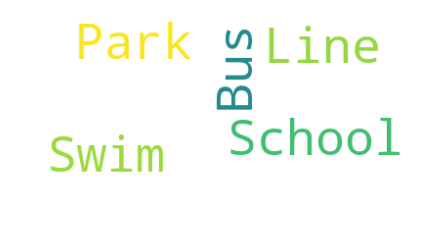


---- Analyziing Little Portugal / Trinity Neighborhood -----




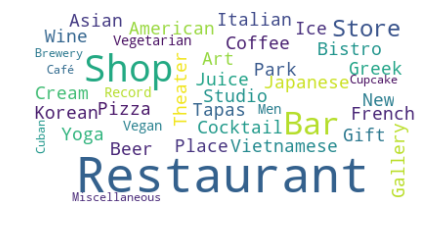


--- Analyziing Moore Park / Summerhill East Neighborhood ---




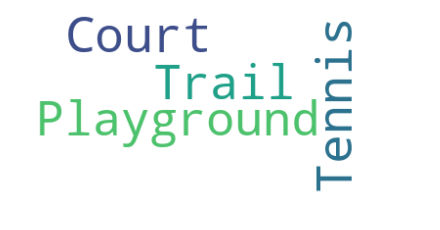


-------- Analyziing North Toronto West Neighborhood --------




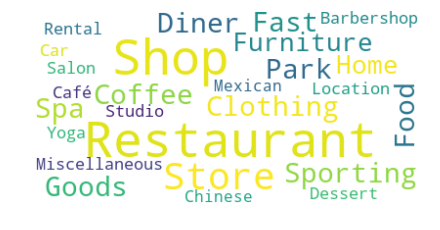


----- Analyziing Parkdale / Roncesvalles Neighborhood ------




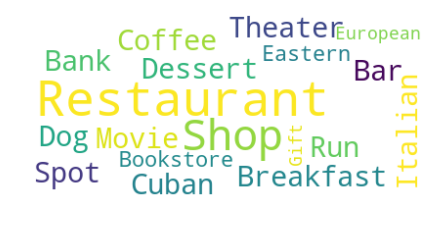


 Analyziing Queen's Park / Ontario Provincial Government Neighborhood 




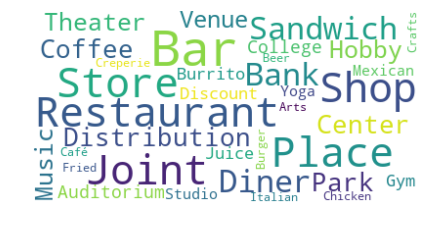


---- Analyziing Regent Park / Harbourfront Neighborhood ----




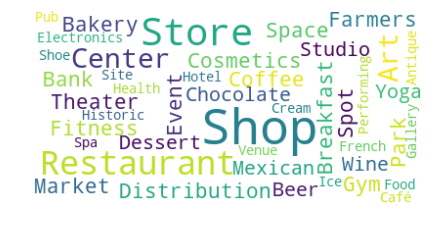


---- Analyziing Richmond / Adelaide / King Neighborhood ----




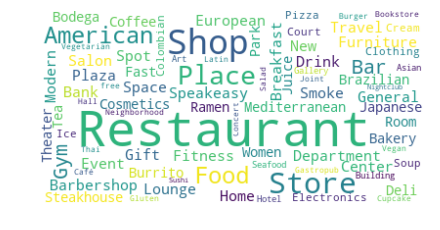


------------- Analyziing Rosedale Neighborhood -------------




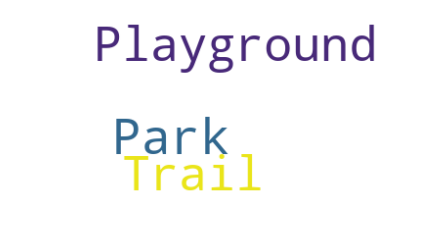


------------- Analyziing Roselawn Neighborhood -------------




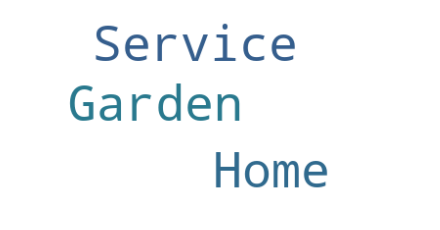


------- Analyziing Runnymede / Swansea Neighborhood --------




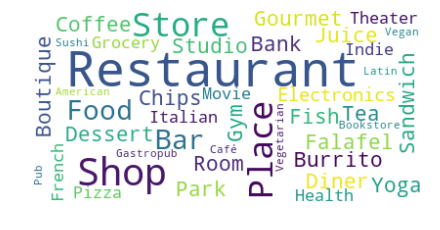


---------- Analyziing St. James Town Neighborhood ----------




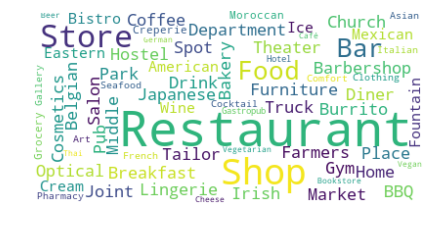


--- Analyziing St. James Town / Cabbagetown Neighborhood ---




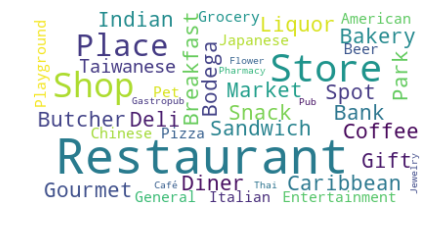


---------- Analyziing Stn A PO Boxes Neighborhood ----------




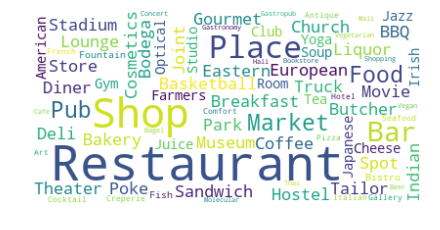


--------- Analyziing Studio District Neighborhood ----------




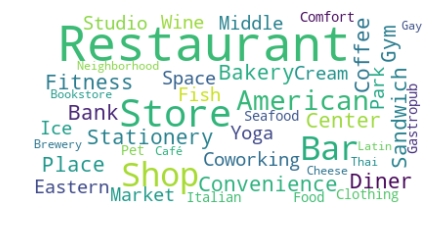


 Analyziing Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park Neighborhood 




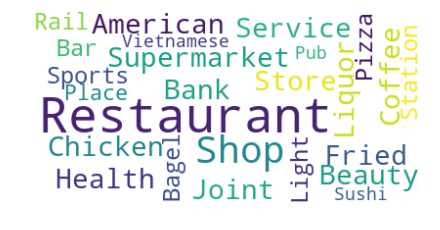


 Analyziing The Annex / North Midtown / Yorkville Neighborhood 




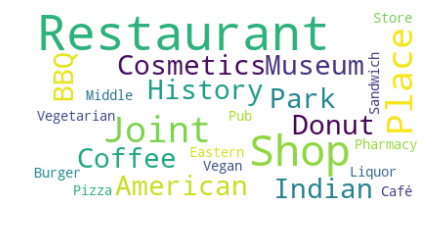


----------- Analyziing The Beaches Neighborhood ------------




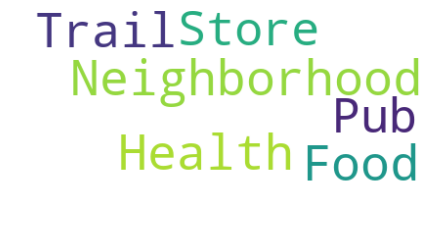


-- Analyziing The Danforth West / Riverdale Neighborhood ---




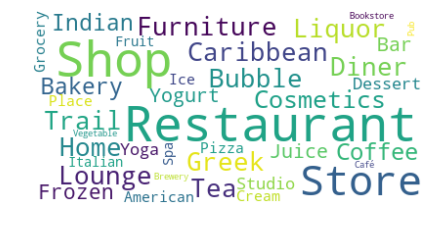


 Analyziing Toronto Dominion Centre / Design Exchange Neighborhood 




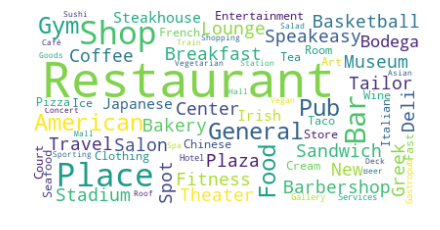


- Analyziing University of Toronto / Harbord Neighborhood --




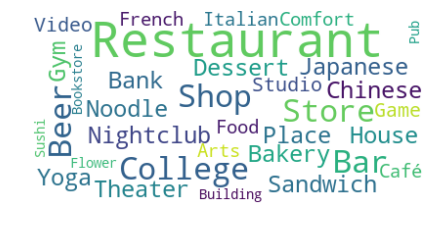

In [58]:
class color:
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

for i,j in df1.iterrows(): 
        word_string_Heading = df1['Neighborhood'][i]
        word_string = df1['Venue Category'][i]
        wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords,background_color='white').generate(word_string)
        print("\n"+ color.RED + " Analyziing {} Neighborhood ".format(word_string_Heading).center(60,"-") + color.END + "\n\n")
        # display the cloud
        fig = plt.figure()
        fig.set_figwidth(7)
        fig.set_figheight(9)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()